<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/dev_01/ROBERTA_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence_transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=34f22039c8139727dda86b6da61da27ff9c26579e4d16b2ab6e8cc51d837a6ad
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer

In [5]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel

In [7]:
ethos_hate = pd.read_csv("ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)


train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

print(train.text[0])


What episode number was this?


In [ ]:
print(test.label)

0     0
1     1
2     0
3     1
4     0
     ..
95    0
96    1
97    0
98    1
99    1
Name: label, Length: 100, dtype: int64


In [ ]:
train.text

0                          What episode number was this?
1      Why don't you go beck your god to murder you? ...
2      I don't like jew soap, but if we are to get ri...
3      By calling period, a natural procedure, as an ...
4         MASS BLACK WORLDWIDE GENOCIDE IS OUR ONLY HOPE
                             ...                        
893    Is this world filled by those stupid female bi...
894                   What type of question it is???????
895                    Die fucking arab dude sand niggas
896               Japanese culture is ancient and unique
897    People who say "YAAAASSSS QUEEN" should be ste...
Name: text, Length: 898, dtype: object

In [8]:
print("Longest sentence?")
print(max(len(x) for x in train.text.values))
print("Average length?")
print(sum(len(x) for x in train.text.values) / len(train.text.values))


Longest sentence?
3009
Average length?
111.76948775055679


In [9]:
def clean_text(line):
  processed_line = line.lower()
  words = [word for word in word_tokenize(processed_line)]
  processed_line = [word for word in words if word not in set(string.punctuation)]
  text = " ".join(processed_line)
  return text

In [10]:
# Sentences for embeddings
train_sentence_list = list(map(clean_text, train.text.values))
test_sentence_list = list(map(clean_text, test.text.values))

In [ ]:
train_sentence_list

In [12]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 128

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [13]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 128

In [14]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [15]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [16]:
X_train = roberta_encode(train_sentence_list, tokenizer)
X_test = roberta_encode(test_sentence_list, tokenizer)

y_train = np.asarray(train.label, dtype='int32').reshape(-1,1)
y_test = np.asarray(test.label, dtype='int32').reshape(-1,1)

In [17]:
def build_model():
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
  x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  x = x[0]

  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [18]:
model = build_model()
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [19]:
print('Training...')
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=16,
                    verbose=1,
                    validation_data=(X_test, y_test))

Training...
Epoch 1/10


57/57 [==============================] - 28s 219ms/step - loss: 0.6195 - accuracy: 0.6392 - val_loss: 0.4864 - val_accuracy: 0.7800
Epoch 2/10
57/57 [==============================] - 10s 168ms/step - loss: 0.4572 - accuracy: 0.7862 - val_loss: 0.4689 - val_accuracy: 0.7700
Epoch 3/10
57/57 [==============================] - 9s 163ms/step - loss: 0.2879 - accuracy: 0.8764 - val_loss: 0.4418 - val_accuracy: 0.7800
Epoch 4/10
57/57 [==============================] - 9s 163ms/step - loss: 0.1485 - accuracy: 0.9410 - val_loss: 0.4753 - val_accuracy: 0.7900
Epoch 5/10
57/57 [==============================] - 9s 163ms/step - loss: 0.1092 - accuracy: 0.9644 - val_loss: 0.5219 - val_accuracy: 0.8100
Epoch 6/10
57/57 [==============================] - 9s 164ms/step - loss: 0.0333 - accuracy: 0.9866 - val_loss: 0.6060 - val_accuracy: 0.8000
Epoch 7/10
57/57 [==============================] - 9s 163ms/step - loss: 0.0196 - accuracy: 0.9955 - val_loss: 0.9262 - val_accuracy: 0.7500
Epoch 8/10
57/5

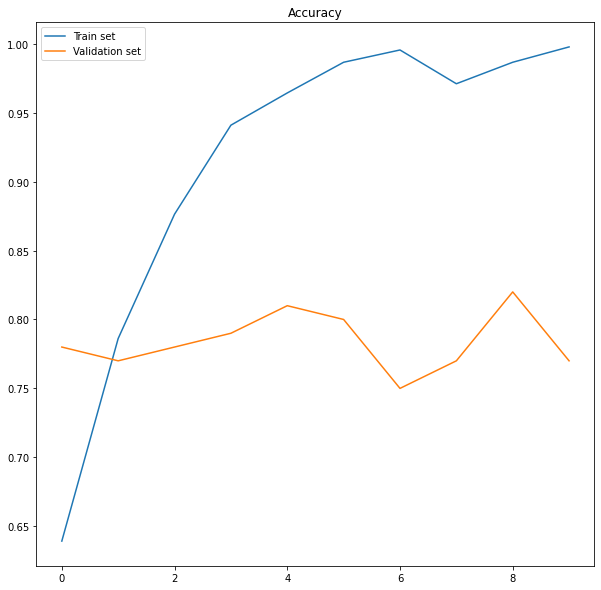

In [20]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()


In [22]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 77.00%


In [23]:
y_pred = [int(np.round(i,0)) for i in model.predict(X_test)]

4/4 [==============================] - 3s 79ms/step


In [ ]:
y_pred

In [ ]:
y_test

In [26]:
from sklearn.metrics import confusion_matrix
con_mat_df = confusion_matrix(y_test, y_pred)
con_mat_df = con_mat_df.astype('float') / con_mat_df.sum(axis=1)[:, np.newaxis]

[[0.75438596 0.24561404]
 [0.20930233 0.79069767]]


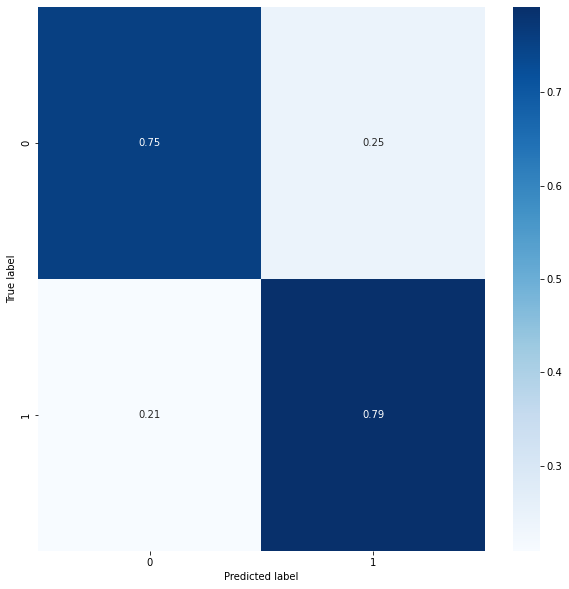

In [27]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(con_mat_df)